# Transforming workflow for coeanography study using S2 data, from SAFE to ZARR

In this notebook we will show the workflow using SAFE, then how to transform the workflow to new EOPF ZARR format. 

First we will show the workflow using SAFE

## WORKFLOW WITH SAFE

We will download the research software frim git repository, also SAFE format S2L1C data 

### download the research software 

In [4]:
!git clone https://github.com/cuevas-a97/S2_Codes.git

Cloning into 'S2_Codes'...
remote: Enumerating objects: 726, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 726 (delta 23), reused 33 (delta 8), pack-reused 669 (from 2)
Receiving objects: 100% (726/726), 283.08 MiB | 39.41 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (601/601), done.


In [4]:
# update the pangeo image 2025.06.01 (verify) 
# also possible to use docker.io/tinaok/eopf-webiner6-docker:latest
!mamba  install libgdal-jp2openjpeg=3.10.3 -y  

/srv/conda/envs/notebook/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=182) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
^C
ERROR: Operation cancelled by user

Pinned packages:

  - python=3.12



### Download the safe format file
#### Import dependencies for downloading Safe format. 

In [9]:
import os
from urllib.parse import urlparse
import random

import boto3
import pystac_client
from dotenv import load_dotenv

###3 Setup and Environment Configuration

First, we'll import the required libraries and set up our environment. Make sure your Copernicus credentials are stored in your environment variables or a `.env` file.


In [10]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")

#### The S3Connector Class

The `S3Connector` class provides an interface to connect to the S3-compatible storage service of the Copernicus Data Space Ecosystem. This class handles authentication and connection management.


In [11]:
class S3Connector:
    """A clean connector for S3-compatible storage services"""

    def __init__(self, endpoint_url, access_key_id,
                 secret_access_key, region_name='default'):
        """Initialize the S3Connector with connection parameters"""
        self.endpoint_url = endpoint_url
        self.access_key_id = access_key_id
        self.secret_access_key = secret_access_key
        self.region_name = region_name

        # Create session
        self.session = boto3.session.Session()

        # Initialize S3 resource
        self.s3 = self.session.resource(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

        # Initialize S3 client
        self.s3_client = self.session.client(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

    def get_s3_client(self):
        """Get the boto3 S3 client"""
        return self.s3_client

    def get_s3_resource(self):
        """Get the boto3 S3 resource"""
        return self.s3

    def get_bucket(self, bucket_name):
        """Get a specific bucket by name"""
        return self.s3.Bucket(bucket_name)

    def list_buckets(self):
        """List all available buckets"""
        response = self.s3_client.list_buckets()
        if 'Buckets' in response:
            return [bucket['Name'] for bucket in response['Buckets']]
        return []

#### Utility Functions

The following function helps convert S3 URIs from the STAC catalog into S3 keys that can be used for direct access.


In [12]:
def extract_s3_path_from_url(url):
    """
    Extracts the S3 object path from an S3 URL or URI.

    This function parses S3 URLs/URIs and returns just the object path portion,
    removing the protocol (s3://), bucket name, and any leading slashes.

    Args:
        url (str): The full S3 URI (e.g., 's3://eodata/path/to/file.jp2')

    Returns:
        str: The S3 object path (without protocol, bucket name and leading slashes)
    """
    # If it's not an S3 URI, return it unchanged
    if not url.startswith('s3://'):
        return url

    # Parse the S3 URI
    parsed_url = urlparse(url)

    # Ensure this is an S3 URL
    if parsed_url.scheme != 's3':
        raise ValueError(f"URL {url} is not an S3 URL")

    # Extract the path without leading slashes
    object_path = parsed_url.path.lstrip('/')

    return object_path

In [13]:
def get_product(s3_resource, bucket_name, object_url, output_path):
    """
    Download a product from S3 bucket and create output directory if it doesn't exist.

    Args:
        s3_resource: boto3 S3 resource object
        bucket_name (str): Name of the S3 bucket
        object_url (str): Path to the object within the bucket
        output_path (str): Local directory to save the file

    Returns:
        str: Path to the downloaded file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Extract filename from the object URL
    _, filename = os.path.split(object_url)

    # Full path where the file will be saved
    local_file_path = os.path.join(output_path, filename)

    print(f"Downloading {object_url} to {local_file_path}...")

    try:
        # Download the file from S3
        s3_resource.Bucket(bucket_name).download_file(object_url, local_file_path)
        print(f"Successfully downloaded to {local_file_path}")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        raise

    return local_file_path

#### Connecting to Copernicus Data Space Ecosystem

Now let's establish connections to both the S3 storage and STAC catalog services using our credentials.


In [14]:
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
BUCKET_NAME = "eodata"
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
print("Available buckets:", buckets)

/srv/conda/envs/notebook/lib/python3.12/site-packages/botocore/crt/auth.py:59: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime_now = datetime.datetime.utcnow().replace(


Available buckets: ['DIAS', 'EODATA']


#### Searching for Sentinel-2 Product

We'll use the STAC API to search for Sentinel-2 Level 2A products based on:
- Geographic location (longitude/latitude point)
- Date range
- Cloud cover threshold

The search results provide metadata and access links to the actual imagery.


### Specific Area

In [18]:

LON, LAT = 111, -26

date = "2024-04-01/2024-04-01"
collections=['sentinel-2-l1c']
# Search for Sentinel-2 products
items_txt = catalog.search(
    collections=collections,
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    datetime=date,
    query=["eo:cloud_cover<50"]
).item_collection()
selected_item = random.choice(items_txt)
selected_item

<Item id=S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723>

#### Downloading Sentinel-2 Product

Once we've identified the product we want, we can download it using our S3 connection.


In [22]:
def download(bucket, product: str, target: str = "") -> str:
    """
    Downloads every file in the S3 bucket with the provided product prefix.
    Creates a local folder named after the .SAFE directory (without the .SAFE extension).

    Args:
        bucket: boto3 Resource bucket object
        product: Path to the product (e.g., 'Sentinel-2/MSI/L2A/.../S2B_MSIL2A_..._T56KKB_20240516T015827.SAFE/')
        target: Local directory to save the files. Defaults to current directory.

    Returns:
        str: Path to the downloaded .SAFE directory (without the .SAFE extension)

    Raises:
        FileNotFoundError: If the product was not found in the bucket
    """
    # Ensure the product path ends with '/'
    if not product.endswith('/'):
        product += '/'

    # List files in the S3 prefix
    files = list(bucket.objects.filter(Prefix=product))
    if not files:
        raise FileNotFoundError(f"Could not find any files for {product}")

    # Extract the .SAFE directory name (e.g., "S2B_MSIL2A_20240516T001109_N0510_R073_T56KKB_20240516T015827.SAFE")
    safe_dir = os.path.basename(product.rstrip('/'))
    if not safe_dir.endswith('.SAFE'):
        raise ValueError(f"Expected a .SAFE directory, got: {safe_dir}")

    # Create the local target directory (without the .SAFE extension)
    # local_dir = safe_dir[:-5]  # Remove '.SAFE' from the name
    local_path = os.path.join(target, safe_dir)

    # Create the local directory structure
    os.makedirs(local_path, exist_ok=True)

    # Download each file while preserving the relative structure
    for file in files:
        # Skip directory markers (S3 pseudo-folders)
        if file.key.endswith('/'):
            continue

        # Compute the relative path inside the .SAFE directory
        relative_path = os.path.relpath(file.key, product)
        local_file_path = os.path.join(local_path, relative_path)

        # Create parent directories if they don't exist
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        # Download the file
        bucket.download_file(file.key, local_file_path)

    return local_path

In [23]:
bucket = s3.Bucket(BUCKET_NAME)
product_url , _ = os.path.split(selected_item.assets['safe_manifest'].href)
product_url = extract_s3_path_from_url(product_url)
safe_filename = download(bucket, product_url, target=".")

/srv/conda/envs/notebook/lib/python3.12/site-packages/botocore/crt/auth.py:59: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime_now = datetime.datetime.utcnow().replace(


#### Verify the downloaded Safe format file in your directory 

In [24]:
!ls

/srv/conda/envs/notebook/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=82) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


LICENSE
README.md
S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE
S2_Codes
environment.yml
tina.ipynb


In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import sys
import os
from scipy.interpolate import interpolate
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.io import savemat
from scipy.io import loadmat
from skimage.filters import sobel

# PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'

#os.chdir('/home/acuevas/Bureau/S2_ALEXANDRA/OPTOOLS/PYTHON/Carte_courant')
import sys
sys.path.append("S2_Codes/fonction")


from spectral_analysis_functions import *
# Using OceanDataLab reader 
#from sentinel2_l1c import *
import numpy as np
from S2_read import *
from s2_angs import *

import warnings
warnings.simplefilter('default')

bands=['B04','B08','B03','B02'];  

#Masha 2016
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PWN_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PXN_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYL_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYM_20160827T065722.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/2016/S2A_MSIL1C_20160827T064622_N0204_R020_T39PYN_20160827T065722.SAFE/'

#Californie 2023
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SBF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SCF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SCG_20230427T223909.SAFE/'

# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDF_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDG_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SBH_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/30_04_2023/S2B_MSIL1C_20230430T190919_N0509_R056_T10SBG_20230430T211611.SAFE'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDG_20230427T223909.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/27_04_2023/S2B_MSIL1C_20230427T185919_N0509_R013_T10SDH_20230427T223909.SAFE/'

 #Australie
S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JEN_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JFM_20240401T054723.SAFE/'
# S2path='/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JFN_20240401T054723.SAFE/'
S2path='./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/'
#S2path=safe_filename+'/'
Sat='A' # should change depending on the satellite S2A or S2b


# Packages

# Image reading 

In [2]:
#!pip install pylibjpeg-openjpeg
#XML_File = find('MTD_TL.xml', S2path)
#XML_File
import rasterio
with rasterio.Env() as env:
    drivers = env.drivers()
    print("JP2OpenJPEG" in drivers)
    print("JP2OpenJPEG mode:", drivers.get("JP2OpenJPEG"))

True
JP2OpenJPEG mode: JPEG-2000 driver based on JP2OpenJPEG library


In [3]:
XML_File = find('MTD_TL.xml', S2path)
XML_File_DS=find('MTD_DS.xml',S2path)
if XML_File is None:
    print("Le fichier 'MTD_TL.xml' n'a pas été trouvé dans le répertoire spécifié:", S2path)


boxi1=[2500,3000,3000,3500] # East West South North : this box is covered by another detector
[imgs1,NX1,NY1,nx1,ny1,dx1,dy1,offspec1,phitrig1,thetav1,loncenter1,latcenter1,detector,indexX,indexY]=S2_read(S2path,boxi1,bands)
boxi=[8000,8500,5000,5500]
[imgs,NX,NY,nx,ny,dx,dy,offspec,phitrig,thetav,loncenter,latcenter,detector,indexX,indexY]=S2_read(S2path,boxi,bands)

# print('Nx',NX)
# print('Ny',NY)
# print('nx',nx)
# print('ny',ny)
# print('dx',dx)
# print('dy',dy)
print(np.degrees(loncenter))
print(np.degrees(latcenter))

test: ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/
Reading XML file for view and sun angles: ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/MTD_TL.xml
Reading file for band  B04 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B04.jp2
Reading file for band  B08 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B08.jp2
Reading file for band  B03 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B03.jp2
Reading file for band  B02 : ./S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA/T49JEM_20240401T024319_B02.jp2
x and y indices in angles arrays: 6 15
ba

/home/acuevas/Bureau/S2_ALEXANDRA/Australie/S2B_MSIL1C_20240401T024319_N0510_R003_T49JEM_20240401T054723.SAFE/GRANULE/L1C_T49JEM_A036923_20240401T024318/IMG_DATA


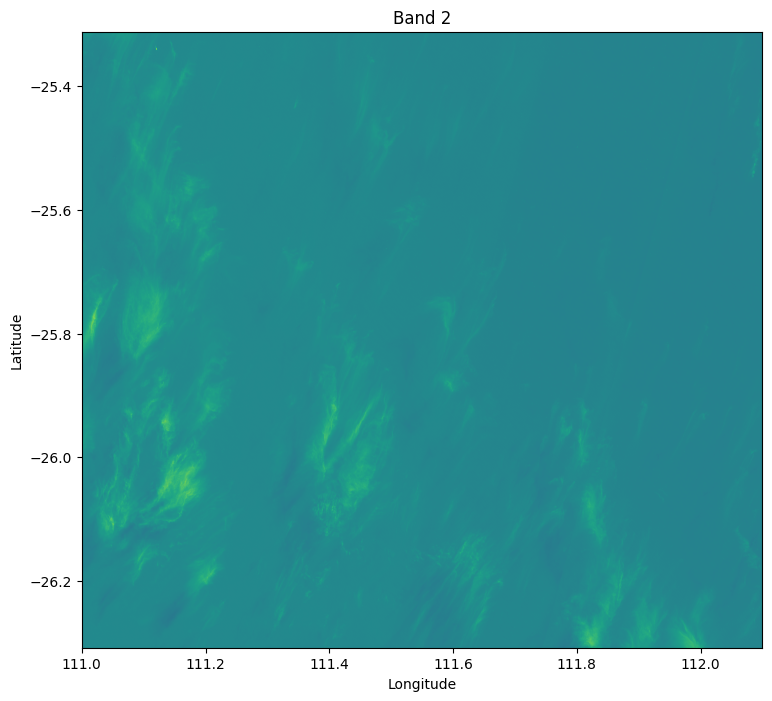

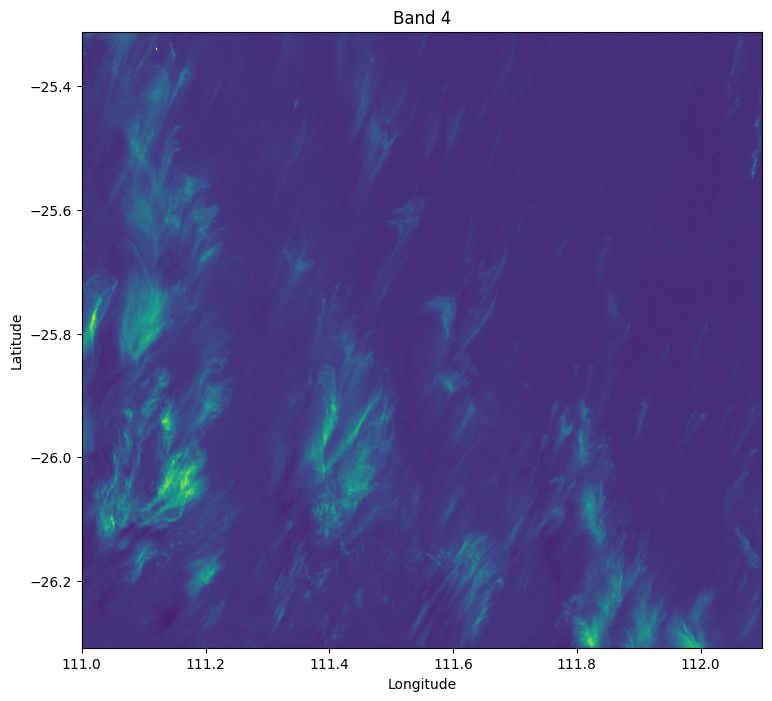

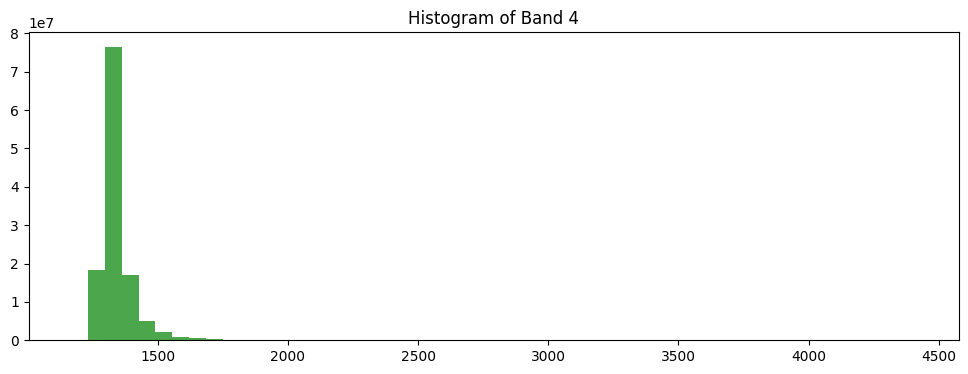

[110.99979963035028, 112.09974791439986, -26.307696430569262, -25.31215761744814]


/tmp/ipykernel_492674/292770347.py:40: UserWarning: Adding colorbar to a different Figure <Figure size 1200x400 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im)


<Figure size 640x480 with 0 Axes>

minlon 110.99979963035028
minlat -26.307696430569262
maxlon 112.09974791439986
maxlat -25.31215761744814


In [179]:
%run Visualisation_image.ipynb

## Image based on detectors

lon,lat: 112.71096832734311 64.40036585069615
means: [1314.  1187.5 1518.  1915.5]
Median brighness in B04 and mss: 1320.0 1308.0 0.6572957404348737 0.990909090909091 1.0431278391291323 20.680323619922547 22.060943594188878


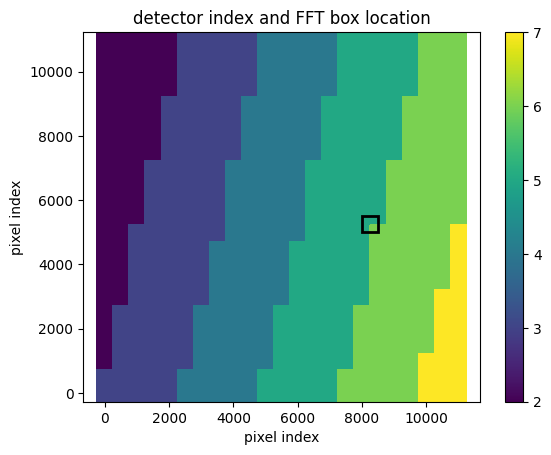

G4 0.32864684103968345
[8000, 8500, 5000, 5500]


In [180]:
print('lon,lat:',np.degrees(loncenter),np.degrees(latcenter))

nb=np.shape(bands)[0]
# Mother_box=[4800,10000,7200,10300]
Mother_box=[2000, 10000, 6000,10000]

taille_boite=500
# taille_boite=700

width=(Mother_box[1] - Mother_box[0]) // taille_boite 
length=(Mother_box[3] - Mother_box[2]) // taille_boite 

# boxi=[6000, 6500, 8000, 8500]
# boxi=[7600,8100,4500,5000]
B04med1=np.median(imgs1[0,:,:].flatten())
B04med=np.median(imgs[0,:,:].flatten())
B08med1=np.median(imgs1[1,:,:].flatten())
B08med=np.median(imgs[1,:,:].flatten())

mediansb=0.5*(np.median(imgs,axis=(1, 2))+np.median(imgs1,axis=(1, 2)))
print('means:',mediansb)

ratio=B04med/B04med1
G4=(B04med-B04med1)/(tan(np.radians(offspec[0]))-tan(np.radians(offspec1[0])))/mediansb[0]
G8=(B08med-B08med1)/(tan(np.radians(offspec[1]))-tan(np.radians(offspec1[1])))/mediansb[1]
                         
Bd1=(np.cos(np.radians(offspec1[0])))**4*np.cos(np.radians(thetav1[0]))
Bd=(np.cos(np.radians(offspec[0])))**4*np.cos(np.radians(thetav[0]))
mss=(np.tan(np.radians(offspec1[0]))**2-np.tan(np.radians(offspec[0]))**2)/np.log(ratio*Bd/Bd1)

print('Median brighness in B04 and mss:',B04med1,B04med,mss,ratio,Bd/Bd1,offspec[0],offspec1[0])
array1=np.squeeze(detector[1,:,:])
fig, ax = plt.subplots() 
im=ax.pcolor(indexX,indexY,array1)
fig.colorbar(im)
ax.set_title('detector index and FFT box location')
ax.set_xlabel('pixel index')
ax.set_ylabel('pixel index')
ax.axis('equal')
rect = mp.patches.Rectangle((boxi[0], boxi[2]), boxi[1]-boxi[0], boxi[3]-boxi[2], linewidth=2,
                         edgecolor='k', facecolor="none")


ax.add_patch(rect)
plt.show()
print('G4',G4)
print(boxi)

## Identifying the detector

In [127]:
# On determine le centre de la boîte en pixel
def centre_carre(x0,xy0,taille_boite):
    centrex=x0+taille_boite/2
    centrey=y0+taille_boite/2
    return centrex, centrey

x0=boxi[0]
y0=boxi[2]
taille_boite=boxi[1]-boxi[0]
centre=centre_carre(x0,y0,taille_boite)

print('centre boxi',centre)

centre boxi (8250.0, 5250.0)


In [128]:
indexX2, indexY2 = np.meshgrid(indexX, indexY)
print('shape indexX',np.shape(indexX))
print('shape indexY',np.shape(indexY))
print('shape array1',np.shape(array1))


points = np.column_stack((indexX.ravel(), indexY.ravel()))
values = array1.ravel()

# Interpolation
value = griddata(points, values, centre, method='linear')
value = value.item() 
detector_find=round(value)
print(detector_find)

shape indexX (23, 23)
shape indexY (23, 23)
shape array1 (23, 23)
3.0
3


## Dictionary of detector numbers

In [129]:
mapping = {
    1: 'D01',
    2: 'D02',
    3: 'D03',
    4: 'D04',
    5: 'D05',
    6: 'D06',
    7: 'D07',
    8: 'D08',
    9: 'D09',
    10: 'D10',
    11: 'D11',
    12: 'D12'
}
if round(value) in mapping:
    Det = mapping[round(value)]
else:
    Det = "Valeur non trouvée"
print(Det)

D03


In [130]:


loncenter2=loncenter*180/(math.pi)
latcenter2=(latcenter*180/math.pi)


print(Det)
print(loncenter2)
print(latcenter2)


D03
51.7556080133623
11.240881062295234


# Image normalisation and filtering

### Normalisation
We look at the band B04 and B02 -->  bands=['B04','B08','B03','B02']; 

546.0
[[541 538 508 ... 564 517 523]
 [565 546 522 ... 584 556 551]
 [556 548 521 ... 639 572 546]
 ...
 [554 545 562 ... 582 572 520]
 [583 583 568 ... 535 573 587]
 [605 547 493 ... 528 573 604]]


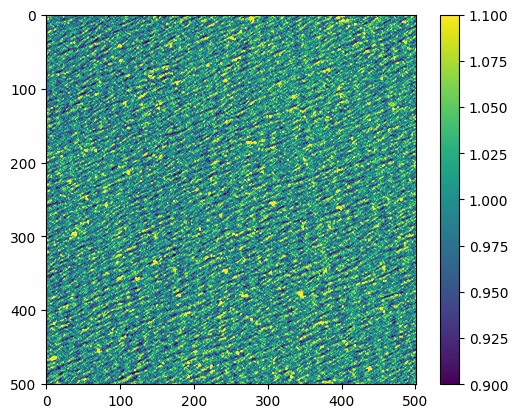

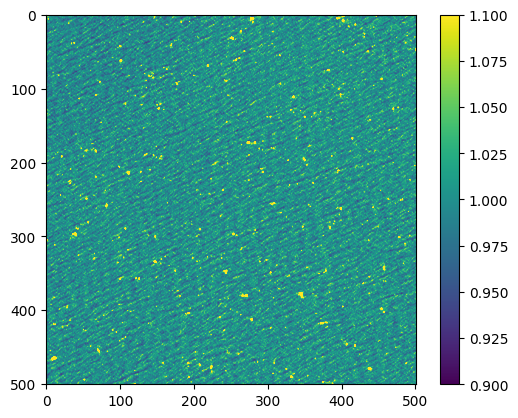

In [153]:
# normalizes the image values
print(np.median(imgs[0,:,:].flatten()))
print(imgs[0,:,:])
img1=imgs[0,:,:]/np.median(imgs[0,:,:].flatten())
img2=imgs[3,:,:]/np.median(imgs[3,:,:].flatten())
plt.imshow(np.flipud(np.transpose(img1)),vmin=0.9, vmax=1.1) #edit your vmin, vmax and cmap if you don't like greyscale colormap
plt.colorbar()

plt.show()
plt.imshow(np.flipud(np.transpose(img2)),vmin=0.9, vmax=1.1) #edit your vmin, vmax and cmap if you don't like greyscale colormap
plt.colorbar()
plt.show()
# Sauvegarder au format .mat
# savemat('imgs_frag1_7km.mat', {'data':imgs})

### Filtering white cap (Sobel filter)

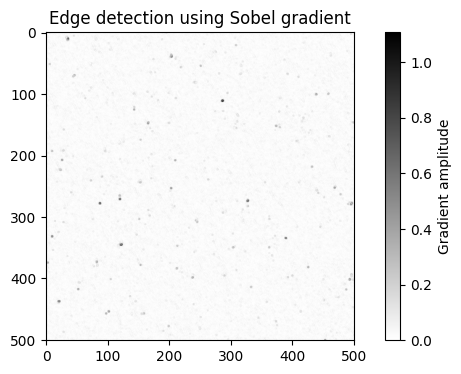

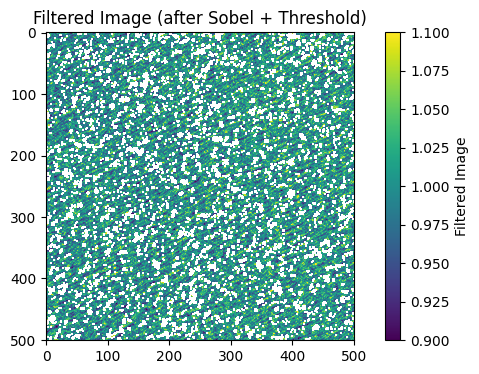

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter

# img_smooth = gaussian_filter(img1, sigma=1)
# gradient_sobel1 = sobel(img_smooth)
# img_smoot2 = gaussian_filter(img2, sigma=1)
# gradient_sobel2 = sobel(img_smoot2)


#Compute the Sobel gradient
gradient_sobel1 = sobel(img1)
gradient_sobel2 = sobel(img2)

# Visualize the gradient
plt.figure(figsize=(8, 4))
plt.imshow(gradient_sobel2, cmap="gist_gray_r", origin="upper")
plt.colorbar(label="Gradient amplitude")
plt.title("Edge detection using Sobel gradient")
plt.show()

# Define an automatic threshold using the 95th percentile
threshold = np.percentile(gradient_sobel1, 95)  
threshold2 = np.percentile(gradient_sobel2, 95)  

# Keep areas with a low gradient
mask = gradient_sobel1 < threshold  
mask2 = gradient_sobel2 < threshold2  

# Apply the mask to the original image
filtered_image1 = np.where(mask, img1, np.nan)  # Replace masked pixels with NaN
filtered_image2 = np.where(mask2, img2, np.nan)  # Replace masked pixels with NaN

# Display the filtered image
plt.figure(figsize=(8, 4))
plt.imshow(np.flipud(np.transpose(filtered_image1)), cmap="viridis", vmin=0.9, vmax=1.1, origin="upper")
plt.colorbar(label="Filtered Image")
plt.title("Filtered Image (after Sobel + Threshold)")
plt.savefig('img1_filtered.png')
plt.show()



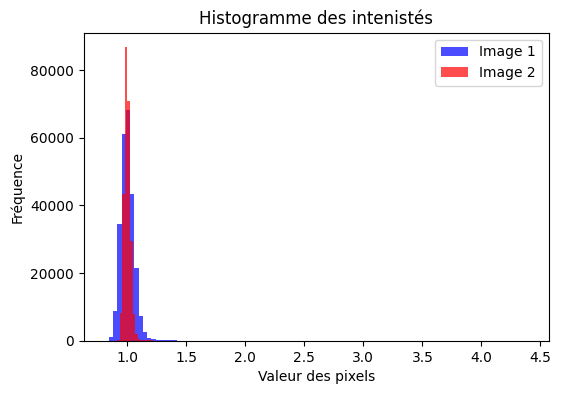

In [163]:
# Display the histogram of values for the original image
plt.figure(figsize=(6, 4))
plt.hist(img1.ravel(), bins=100, color='blue', alpha=0.7, label='Image 1')
plt.hist(img2.ravel(), bins=100, color='red', alpha=0.7, label='Image 2')
plt.xlabel("Values of pixels")
plt.ylabel("Fréquency")
plt.title("Histogramme intensity")
plt.legend()
plt.show()


# Fourier transform with two images

ntile: numbers of tile used for the welch. In the function FTT2D_two_arrays_nonan replaces the nan values in the images with the local mean. The function used when the image is not filtered is FFT2D _two_arrays

spectrum of the brightness of image\
coherence and phase between two images tzo bands \

this notebook show hz to get wave information from S2 L1C image. 


(31, 31)
(31, 31)
(31, 31)
variance 1: 0.0042981493867322 sum of spectrum: 0.0025608144791803805
variance 2: 0.0011313706681378942 sum of spectrum: 0.0005851450308107152


/tmp/ipykernel_492674/93120645.py:68: RuntimeWarning: invalid value encountered in log10
  im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))


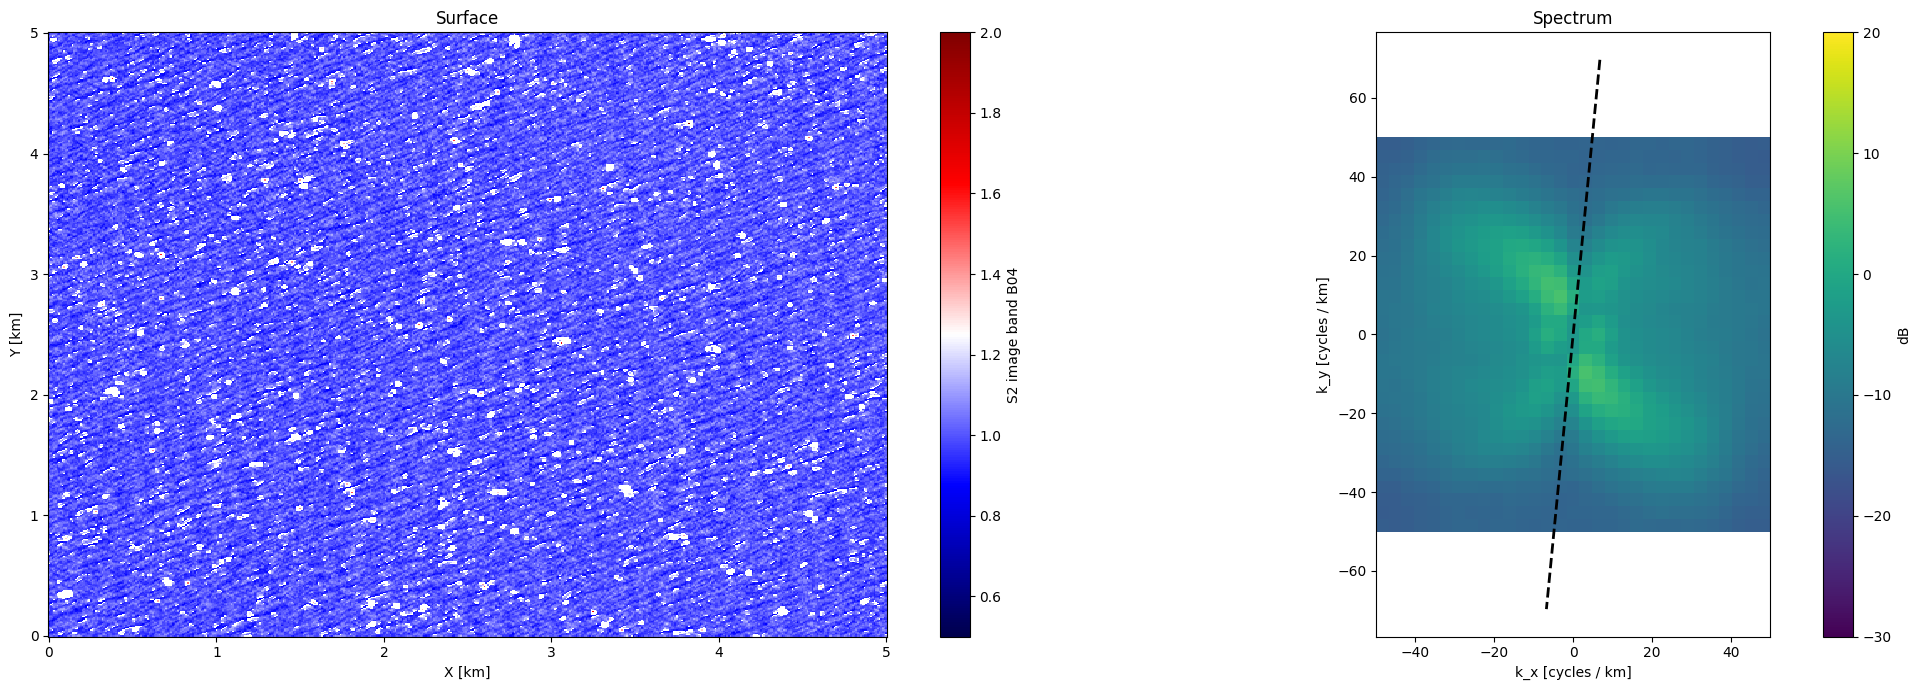

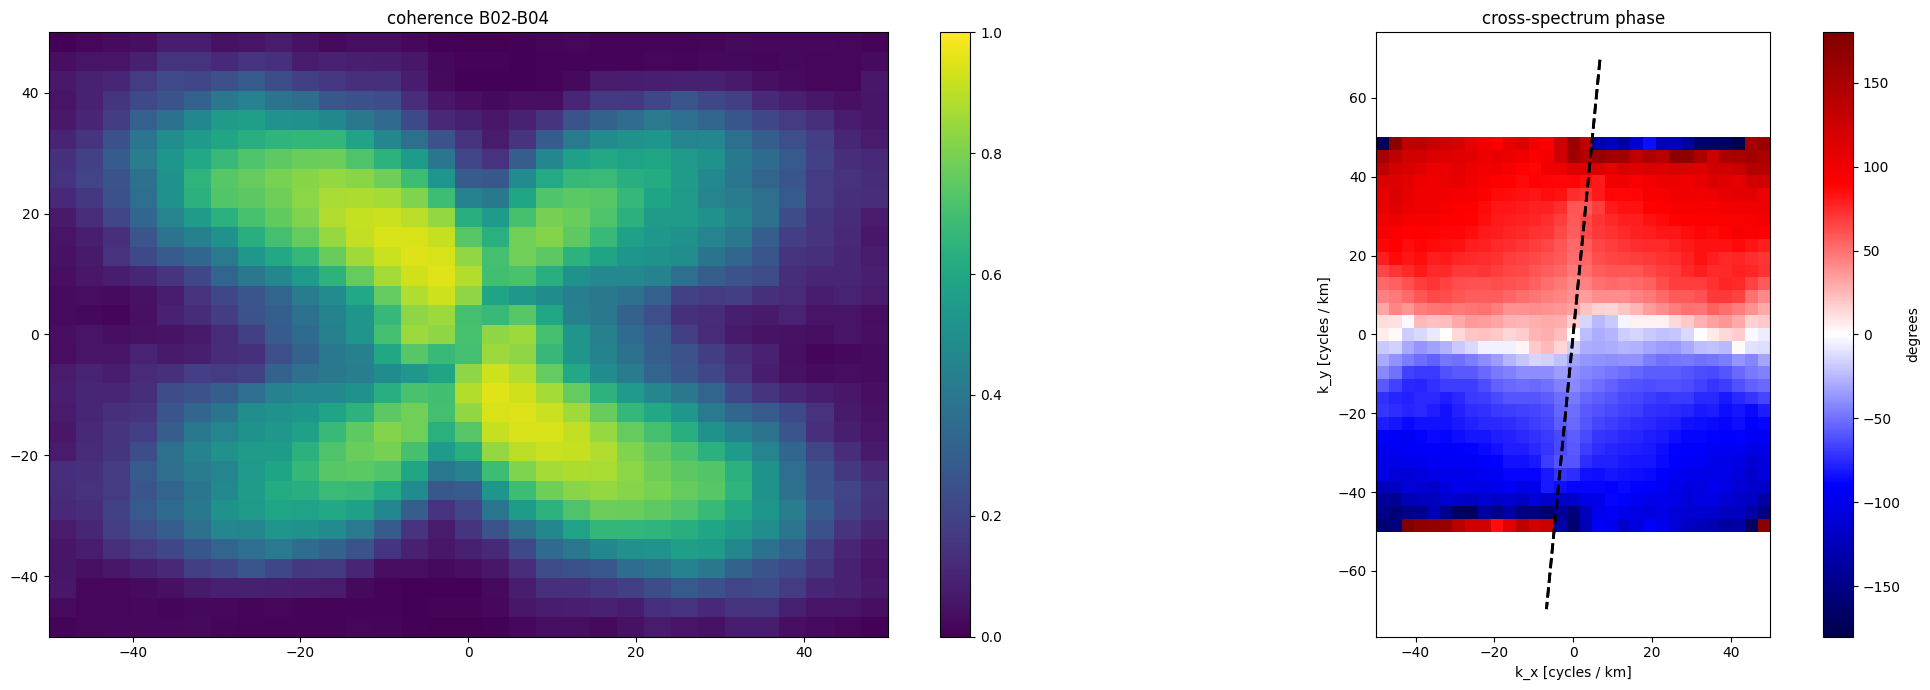

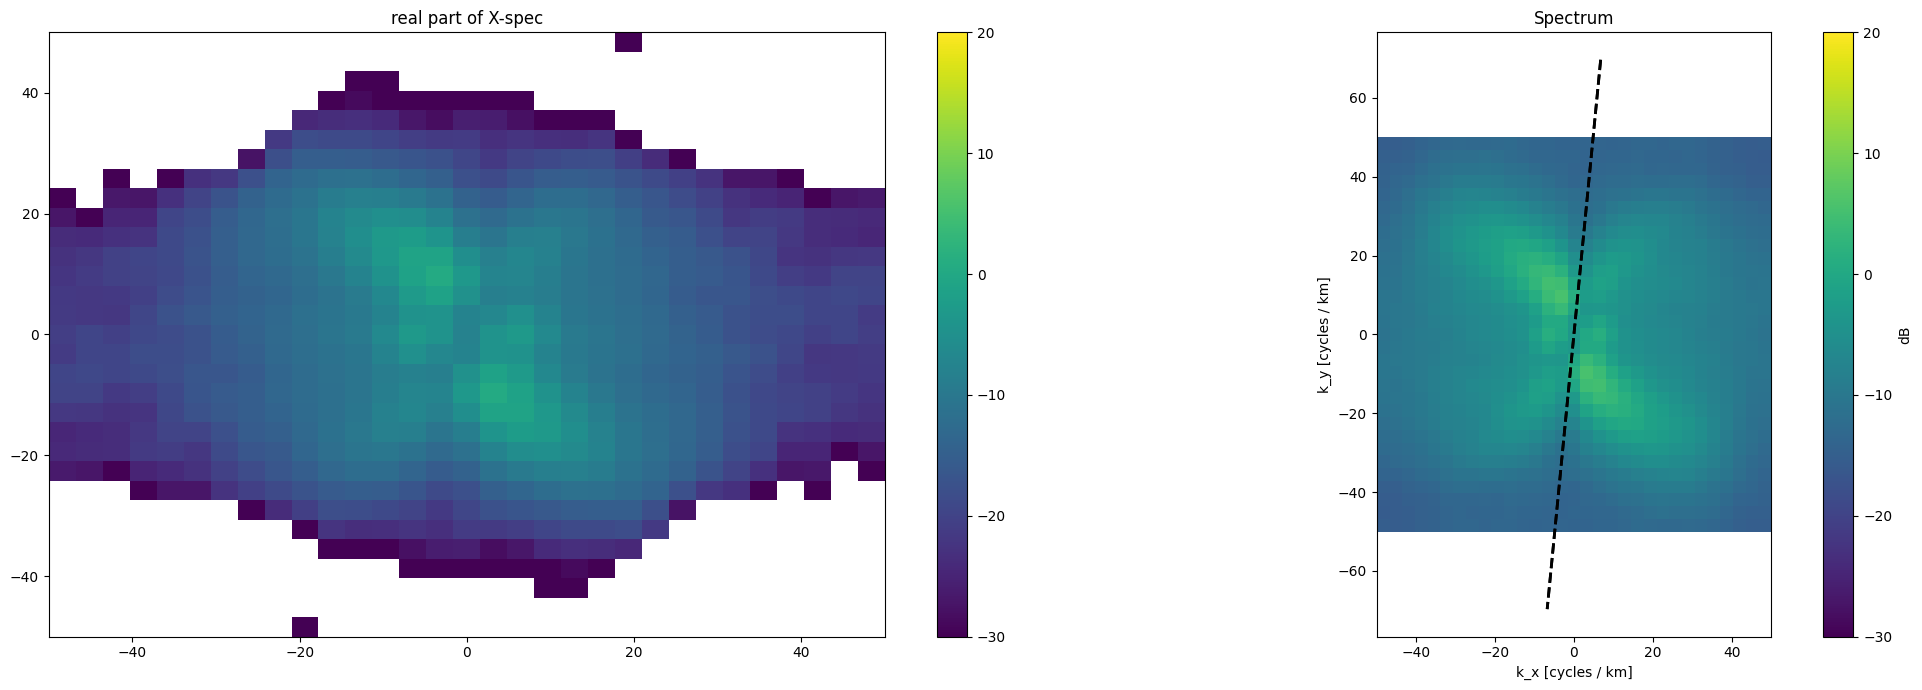

In [166]:

ntile=16
# (Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays(img1,img2,10,10,ntile,isplot=0)
(Eta,Etb,ang,angstd,coh,crosr,phases,kx2,ky2,dkx,dky)=FFT2D_two_arrays_nonan(filtered_image1,filtered_image2,10,10,ntile,isplot=0)

print(np.shape(Eta))
print(np.shape(kx2))
print(np.shape(ky2))


phiblind1=phitrig[0]+90.  # blind azimuth for first band
phiblind2=phitrig[1]+90.  # blind azimuth for 3rd band
phiblind3=phitrig[2]+90.  # blind azimuth for 3rd band
kN=50
xkblind=[-1.4*kN*np.sin(np.radians(phiblind2)) , 1.4*kN*np.sin(np.radians(phiblind2))]
ykblind=[-1.4*kN*np.cos(np.radians(phiblind2)) , 1.4*kN*np.cos(np.radians(phiblind2))]


X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy)

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

# warning: we use an array img1 that is written with X in the first (number 0) dimension and Y in the second
#          but pcolormesh uses the opposite order: hence the use of transpose 

im=axs[0].pcolormesh(X/1000,Y/1000,np.transpose(filtered_image1),cmap='seismic',norm = mcolors.Normalize(vmin=0.5, vmax=2))
_=plt.colorbar(im,ax=axs[0],label='S2 image band B04')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()

print('variance 1:',np.var(img1.flatten()), 'sum of spectrum:',np.sum(Eta.flatten())*dkx*dky )
print('variance 2:',np.var(img2.flatten()), 'sum of spectrum:',np.sum(Etb.flatten())*dkx*dky )


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('coherence B02-B04')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,np.degrees(ang),cmap='seismic',norm = mcolors.Normalize(vmin=-180, vmax=180))
_=plt.colorbar(im,ax=axs[1],label='degrees')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('cross-spectrum phase')
_=plt.tight_layout()

fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*1000,ky2*1000,10*np.log10((crosr)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[0].set_title('real part of X-spec')

im=axs[1].pcolormesh(kx2*1000,ky2*1000,10*np.log10((Eta)),norm = mcolors.Normalize(vmin=-30, vmax=20))
_=plt.colorbar(im,ax=axs[1],label='dB')
_=plt.plot(xkblind,ykblind,color='k',linestyle='--',linewidth=2)
_=axs[1].set_xlabel('k_x [cycles / km]')
_=axs[1].set_ylabel('k_y [cycles / km]')
_=axs[1].set_title('Spectrum')
_=plt.tight_layout()


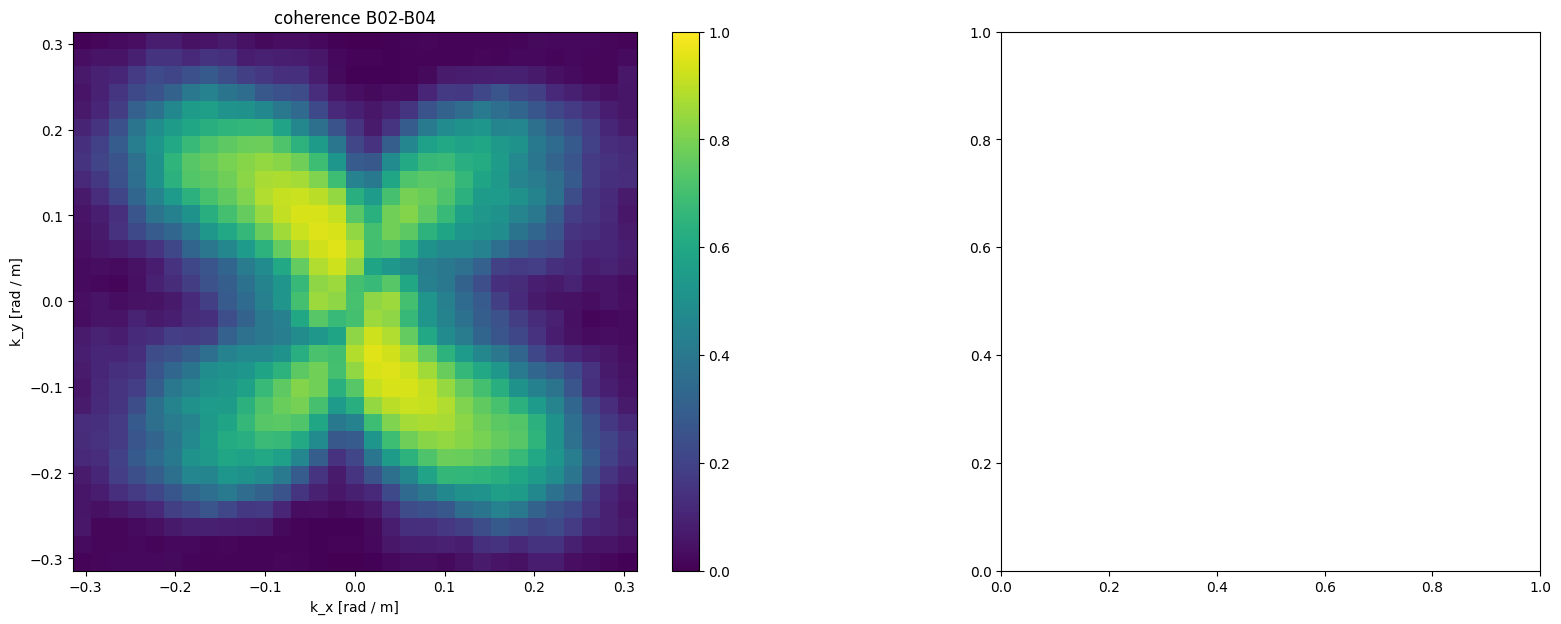

In [167]:
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
_=plt.gca().set_aspect('equal', adjustable='box')

im=axs[0].pcolormesh(kx2*2*np.pi,ky2*2*np.pi,coh,norm = mcolors.Normalize(vmin=0, vmax=1))
_=plt.colorbar(im,ax=axs[0],label=' ')
_=axs[0].set_xlabel('k_x [rad / m]')
_=axs[0].set_ylabel('k_y [rad / m]')
_=axs[0].set_title('coherence B02-B04')


In [168]:
# %run spectral_analysis_functions.py